# Model Soups: averaging weights of multiple fine-tuned models

Автор: [Владимир Карлов](https://t.me/vladimir_karlov)

##### [Ссылка на оригинал статьи](https://arxiv.org/pdf/2203.05482.pdf)   
##### [Ссылка на авторский код](https://github.com/mlfoundations/model-soups)  

# NLP Classification Task

### Попытаемся возпроизвести результаты на текстовой классификации полностью самостоятельно! 
#### Будем предсказывать эмоциональную окраску отзыва с IMDB. Скачаем для этого [довольно известный датасет c Hugging Face](https://huggingface.co/datasets/imdb). 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import random
import seaborn as sns

import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset

In [2]:
seed = 42 

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(seed)

In [3]:
df = load_dataset('imdb')['train']

Found cached dataset imdb (C:/Users/karlo/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
pd.DataFrame(df)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


C:\Users\karlo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

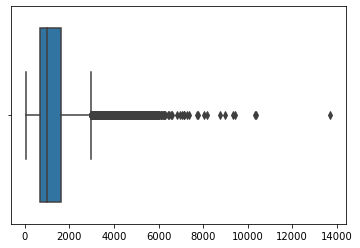

In [5]:
lens = [len(t) for t in df['text']]
sns.boxplot(lens)

In [6]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [7]:
encoded_corpus = tokenizer(text=df['text'],
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=500,
                            return_attention_mask=True)

input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [8]:
from sklearn.model_selection import train_test_split

labels = np.array(df['label'])

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=seed, test_size=0.01)
train_masks, val_masks = train_test_split(attention_mask, random_state=seed, test_size=0.01)

In [9]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16
eval_batch_size = 32


def create_dataloaders(inputs, masks, score, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    score_tensor = torch.tensor(score)
    dataset = TensorDataset(input_tensor, mask_tensor, score_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks, train_labels, batch_size)
val_dataloader = create_dataloaders(val_inputs, val_masks, val_labels, eval_batch_size)

dls = {'train': train_dataloader, 'val': val_dataloader}

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=5e-4)
loss_function = nn.CrossEntropyLoss()

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=150, num_training_steps=total_steps)

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
    
model.to(device)
torch.manual_seed(seed)

In [ ]:
metrics_dict = {
    "Epoch": [],
    "Train Acc": [],
    "Train F-score": [],
    "Val Acc": [],
    "Val F-score": [],
}

# Train loop
for epoch in range(epochs):
    train_prediction = np.array([])
    train_true = np.array([])
    val_prediction = np.array([])
    val_true = np.array([])

    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'val']:

        with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
            if stage == 'train':
                model.train() # Enable some "special" layers (will speak about later)
            else:
                model.eval() # Disable some "special" layers (will speak about later)

            for step, batch in enumerate(tqdm(dls[stage])):                
                batch_inputs, batch_mask, batch_labels = tuple(b.to(device) for b in batch)
                output = model(batch_inputs, batch_mask, labels=batch_labels.to(torch.long))
                logits = output.logits.squeeze()
                
                loss = output.loss
#                 loss = loss_function(logits, batch_labels) # ¡Important! y_pred is always the first arg
#                 print(loss)

                if stage == "train":
                    loss.backward() # Calculate the gradients of all the parameters wrt loss
                    optimizer.step() # Update the parameters
                    scheduler.step()
                    optimizer.zero_grad() # Zero the saved gradient
                    
                with torch.no_grad():
                    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
                
                    if stage == "train":
                        train_true = np.append(train_true, batch_labels.detach().cpu().numpy())
                        train_prediction = np.append(train_prediction, preds)
                    elif stage == "val":
                        val_true = np.append(val_true, batch_labels.detach().cpu().numpy())
                        val_prediction = np.append(val_prediction, preds)
                    
            if stage == "train":
                metrics_dict[f"{stage.title()} Acc"].append(accuracy_score(train_true, train_prediction))
                metrics_dict[f"{stage.title()} F-score"].append(f1_score(train_true, train_prediction))
            else:             
                metrics_dict[f"{stage.title()} Acc"].append(accuracy_score(val_true, val_prediction))
                metrics_dict[f"{stage.title()} F-score"].append(f1_score(val_true, val_prediction))
                
    path = "distillBert_4_states/state_dict_model_%i.pt" % (epoch)     
    torch.save(model.state_dict(), path) 
    
    clear_output(wait=True)
    
    display(pd.DataFrame(metrics_dict))

## Сохранил примеры метрик при обучении стейтов

#### 2-я модель:
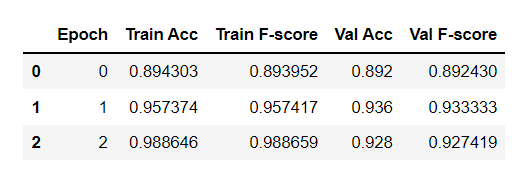

#### 3-я модель: 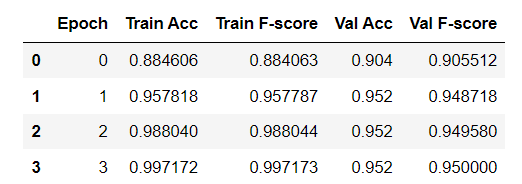

### Посмотрим на поведение обученных моделей на тестовой выборке

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
import datasets

import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset

In [11]:
seed = 42 

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(seed)

In [12]:
torch.cuda.empty_cache()

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
    
torch.manual_seed(seed)

Using GPU.


In [14]:
states = ['distillBert_1_states/state_dict_model_2.pt', 
          'distillBert_2_states/state_dict_model_2.pt',
          'distillBert_3_states/state_dict_model_3.pt',
          'distillBert_4_states/state_dict_model_2.pt']

state_dicts = []
names = [f'Model {i+1}' for i in range(len(states))]

for f in states:
    print(f'Loading {f}')
    state_dicts.append(torch.load(f, map_location=device))

Loading distillBert_1_states/state_dict_model_2.pt
Loading distillBert_2_states/state_dict_model_2.pt
Loading distillBert_3_states/state_dict_model_3.pt
Loading distillBert_4_states/state_dict_model_2.pt


In [15]:
raw_test = load_dataset('imdb')['test']
inds_to_sample = np.random.randint(low=0, high=len(raw_test), size=10000)
test_df = raw_test.select(inds_to_sample)

Found cached dataset imdb (C:/Users/karlo/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
pd.DataFrame(test_df)

,text,label
0,The show itself basically reflects the typical...,1
1,"A film is beyond all expectations, an excellen...",1
2,Without being really the worst science fiction...,0
3,'Illuminata' has expanded the limits of John T...,0
4,It's possible to have a good time with this fi...,1
...,...,...
9995,Ross Hunter's musical remake of the 1937 fanta...,1
9996,This is an engrossing woman's drama that men c...,1
9997,i love this movie. it focuses on both issues: ...,1
9998,I love this film (dont know why it is called P...,1


In [17]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

encoded_corpus = tokenizer(text=test_df['text'],
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=500,
                            return_attention_mask=True)

test_input_ids = encoded_corpus['input_ids']
test_attention_mask = encoded_corpus['attention_mask']

In [18]:
from torch.utils.data import TensorDataset, DataLoader

eval_batch_size = 32

def create_test_dataloader(inputs, masks, eval_batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    dataset = TensorDataset(input_tensor, mask_tensor)
    dataloader = DataLoader(dataset, batch_size=eval_batch_size, shuffle=False)
    return dataloader

test_dataloader = create_test_dataloader(test_input_ids, test_attention_mask, eval_batch_size)

In [19]:
def predict(model, test_dataloader, device='cuda:0'): 
        model.eval()
        test_prediction = np.array([])
        with torch.no_grad():
            for step, batch in enumerate(tqdm(test_dataloader)):
                batch_inputs, batch_mask = tuple(b.to(device) for b in batch)
                output = model(batch_inputs, batch_mask)
                logits = output.logits.squeeze()
                preds = np.argmax(logits.detach().cpu().numpy(), axis=1)

                test_prediction = np.append(test_prediction, preds)

        return test_prediction
    
def predict_val(model, val_dataloader, device='cuda:0'): 
        val_true = np.array([])
        model.eval()
        val_prediction = np.array([])
        with torch.no_grad():
            for step, batch in enumerate(tqdm(val_dataloader)):
                batch_inputs, batch_mask, batch_labels = tuple(b.to(device) for b in batch)
                output = model(batch_inputs, batch_mask)
                logits = output.logits.squeeze()
                preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
                val_true = np.append(val_true, batch_labels.cpu().numpy())                

                val_prediction = np.append(val_prediction, preds)
                
        return accuracy_score(val_true, val_prediction)

In [20]:
test_results = []
val_results = []

In [21]:
from transformers import DistilBertForSequenceClassification

state_path = state_dicts[0]
for i in range(len(state_dicts)):
    cur_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    cur_model.load_state_dict(state_dicts[i])
    cur_model.to(device)
    
    # get accuracy on test set for each model
    cur_pred = predict(cur_model, test_dataloader, device)
    test_results.append(accuracy_score(test_df['label'], cur_pred))
    torch.cuda.empty_cache()
    
    # get accuracy on val set for each model (for greeady soup)
    val_acc = predict_val(cur_model, dls['val'], device)
    val_results.append(val_acc)
    torch.cuda.empty_cache()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [84]:
def show_results(names, test_results):
    plt.bar(names, test_results)
    plt.title("Test Accuracy By Model")
    plt.ylim([0.9, 0.97])
    plt.xticks(rotation=30, ha='right')
    plt.show()
    
    for name, res in zip(names, test_results):
        print('%s : %.4f' % (name, res))

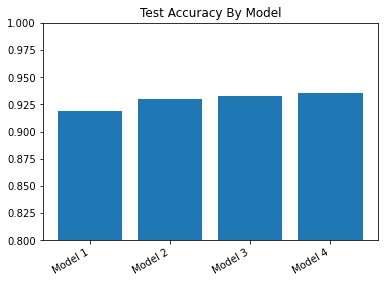

Model 1 : 0.9190
Model 2 : 0.9305
Model 3 : 0.9332
Model 4 : 0.9358


In [23]:
show_results(names, test_results)

## Построим Uniform Soup

In [24]:
def get_model(state_dicts, alphal, device='cuda'):
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
    for i in range(1, len(state_dicts)):
        for k in state_dicts[i].keys():
            sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
    model.load_state_dict(sd)
    model = model.to(device)
    return model

In [25]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
uniform_soup_model = get_model(state_dicts, alphal)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [26]:
uniform_soup_pred = predict(uniform_soup_model, test_dataloader, device)
test_results.append(accuracy_score(test_df['label'], uniform_soup_pred))
names.append('Uniform Soup')
torch.cuda.empty_cache()

  0%|          | 0/313 [00:00<?, ?it/s]

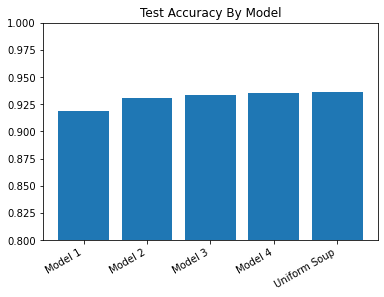

Model 1 : 0.9190
Model 2 : 0.9305
Model 3 : 0.9332
Model 4 : 0.9358
Uniform Soup : 0.9365


In [27]:
show_results(names, test_results)

## Построим Greedy Soup

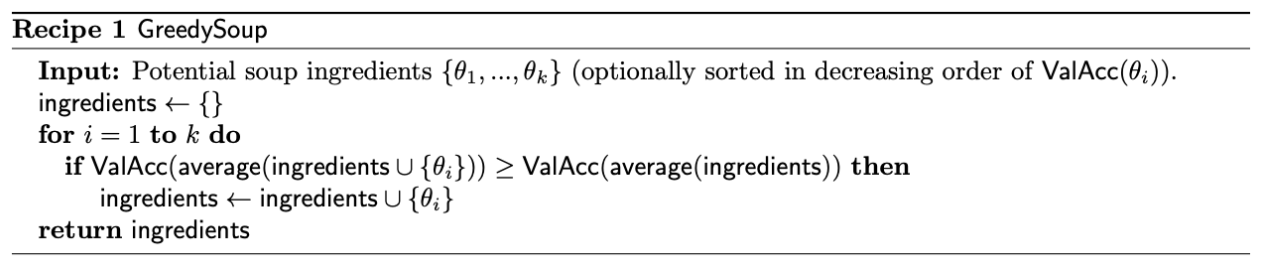

In [28]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
    # add current index to the ingredients
    ingredient_indices = best_ingredients \
      + [ranked_candidates[i]]
    alphal = [0 for i in range(len(state_dicts))]
    for j in ingredient_indices:
        alphal[j] = 1 / len(ingredient_indices)
  
    # benchmark and conditionally append
    model = get_model(state_dicts, alphal)
    current = predict_val(model, val_dataloader)
    print(f'Models {ingredient_indices} got {current * 100}% on validation.')
    if current > current_best:
        current_best = current
        best_ingredients = ingredient_indices

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/8 [00:00<?, ?it/s]

Models [2, 3] got 94.39999999999999% on validation.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/8 [00:00<?, ?it/s]

Models [2, 1] got 94.8% on validation.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/8 [00:00<?, ?it/s]

Models [2, 0] got 94.8% on validation.


In [29]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
    alphal[j] = 1 / len(best_ingredients)
    
greedy_model = get_model(state_dicts, alphal)

greedy_pred = predict(greedy_model, test_dataloader, device)
test_results.append(accuracy_score(test_df['label'], greedy_pred))
names.append('Greedy Soup')
torch.cuda.empty_cache()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

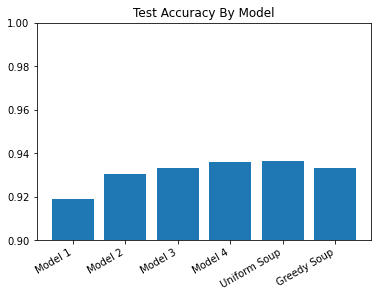

Model 1 : 0.9190
Model 2 : 0.9305
Model 3 : 0.9332
Model 4 : 0.9358
Uniform Soup : 0.9365
Greedy Soup : 0.9332


In [32]:
show_results(names, test_results)

## Опробую также собственные идеи по выбору ингредиентов 

### 1. linear_descending_soup: линейные веса для отсортированных по убыванию val accuracy стейтов


In [122]:
alphal = np.zeros(len(state_dicts))
sorted_inds = np.argsort(val_results)
alphal[sorted_inds] = np.arange(len(state_dicts))
alphal = alphal / np.sum(alphal)

linear_soup_model = get_model(state_dicts, alphal)
linear_pred = predict(linear_soup_model, test_dataloader, device)
test_results.append(accuracy_score(test_df['label'], linear_pred))
names.append('Linear Soup')
torch.cuda.empty_cache()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

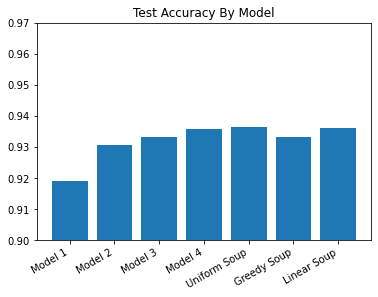

Model 1 : 0.9190
Model 2 : 0.9305
Model 3 : 0.9332
Model 4 : 0.9358
Uniform Soup : 0.9365
Greedy Soup : 0.9332
Linear Soup : 0.9362


In [123]:
show_results(names, test_results)

### 2. softmax_vall_acc_soup: веса, инициализированные как софтмакс (с температурой и без) от val accuracy


In [124]:
def softmax(input, t=1.0):
    ex = torch.exp(input / t)
    sum = torch.sum(ex, axis=0)
    return ex / sum

In [125]:
alphal = softmax(torch.Tensor(val_results))

softmax_soup_model = get_model(state_dicts, alphal)
softmax_pred = predict(softmax_soup_model, test_dataloader, device)
test_results.append(accuracy_score(test_df['label'], softmax_pred))
names.append('Softmax Soup')
torch.cuda.empty_cache()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/313 [00:00<?, ?it/s]

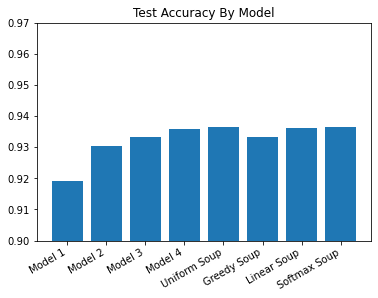

Model 1 : 0.9190
Model 2 : 0.9305
Model 3 : 0.9332
Model 4 : 0.9358
Uniform Soup : 0.9365
Greedy Soup : 0.9332
Linear Soup : 0.9362
Softmax Soup : 0.9365


In [126]:
show_results(names, test_results)

### Дальнейшие направления для экспериментов:

1. Исследования на более сложных задачах (NER, Summarization, NMT)
2. Эксперименты с методами / стратегиями усреднения компонентов

Спасибо, что досмотрели до конца!